<a href="https://colab.research.google.com/github/GentaKanno/TYUSHUTU2/blob/main/tyushutu2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#txtを正方形pngへ変換
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# TXT読み込み
txt_file = "A.txt"
df = pd.read_csv(txt_file, sep=',')
df[['x','y','stroke_id']] = df[['x','y','stroke_id']].astype(float)

# 元のバウンディングボックス
x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()
w, h = x_max - x_min, y_max - y_min

# 出力サイズ
out_size = 256
margin = 20  # 周囲に余白（任意で調整）

# スケーリング係数（長辺を out_size - 2*margin に収める）
scale = (out_size - 2*margin) / max(w, h)

# 出力キャンバス
img = np.ones((out_size, out_size, 3), dtype=np.uint8) * 255

# ストロークごとに描画
for sid in df['stroke_id'].unique():
    stroke = df[df['stroke_id'] == sid].reset_index(drop=True)
    for i in range(1, len(stroke)):
        x0 = int((stroke.loc[i-1, 'x'] - x_min) * scale + margin + (out_size - 2*margin - w*scale)/2)
        y0 = int((stroke.loc[i-1, 'y'] - y_min) * scale + margin + (out_size - 2*margin - h*scale)/2)
        x1 = int((stroke.loc[i, 'x'] - x_min) * scale + margin + (out_size - 2*margin - w*scale)/2)
        y1 = int((stroke.loc[i, 'y'] - y_min) * scale + margin + (out_size - 2*margin - h*scale)/2)
        cv.line(img, (x0, y0), (x1, y1), (0,0,0), 2)

# 保存
cv.imwrite("A.png", img)

True

In [47]:
#外接矩形の縦横比
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒→白に反転） ---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 輪郭抽出（全ての外側輪郭） ---
contours, _ = cv.findContours(bin_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# --- すべての輪郭の座標を統合して外接矩形を求める ---
x_min = min([cv.boundingRect(c)[0] for c in contours])
y_min = min([cv.boundingRect(c)[1] for c in contours])
x_max = max([cv.boundingRect(c)[0] + cv.boundingRect(c)[2] for c in contours])
y_max = max([cv.boundingRect(c)[1] + cv.boundingRect(c)[3] for c in contours])

# --- 幅・高さ・面積 ---
w = x_max - x_min
h = y_max - y_min
aspect_ratio = h / w

print(f"外接矩形: x={x_min}, y={y_min}, w={w}, h={h}")
print(f"外接矩形の縦横比: {aspect_ratio}")

外接矩形: x=19, y=43, w=219, h=170
外接矩形の縦横比: 0.776255707762557


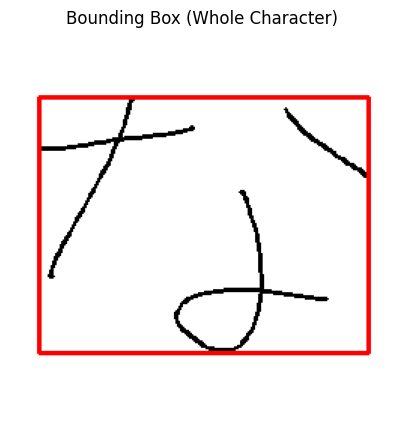

In [48]:
# --- 外接矩形を描画 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.rectangle(vis, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

# --- matplotlibで表示 ---
plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title("Bounding Box (Whole Character)")
plt.axis("off")
plt.show()

45°固定回転後の外接矩形 幅=208, 高さ=200
縦横比（長辺/短辺）= 1.040


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans.
  fig.canvas

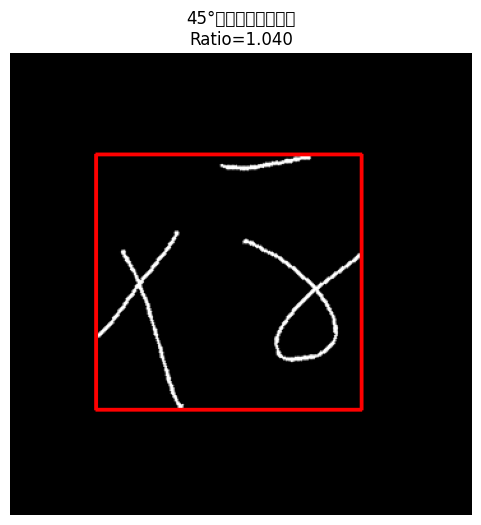

In [49]:
#45°外接矩形の縦横比
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字を白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 画像サイズと中心 ---
h, w = bin_img.shape
center = (w / 2, h / 2)

# --- ① 画像を45°回転 ---
angle = 45
rot_mat = cv.getRotationMatrix2D(center, angle, 1.0)

# 回転後に全領域を収めるサイズを確保
cos_a = abs(rot_mat[0, 0])
sin_a = abs(rot_mat[0, 1])
new_w = int((h * sin_a) + (w * cos_a))
new_h = int((h * cos_a) + (w * sin_a))

# 平行移動を補正（中心をずらさないように）
rot_mat[0, 2] += (new_w / 2) - center[0]
rot_mat[1, 2] += (new_h / 2) - center[1]

rotated = cv.warpAffine(bin_img, rot_mat, (new_w, new_h), flags=cv.INTER_LINEAR, borderValue=0)

# --- ② 回転後の黒画素の外接矩形 ---
ys, xs = np.where(rotated > 0)
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

bbox_w = x_max - x_min
bbox_h = y_max - y_min
ratio = max(bbox_w, bbox_h) / min(bbox_w, bbox_h)

print(f"45°固定回転後の外接矩形 幅={bbox_w}, 高さ={bbox_h}")
print(f"縦横比（長辺/短辺）= {ratio:.3f}")

# --- ③ 可視化 ---
vis = cv.cvtColor(rotated, cv.COLOR_GRAY2BGR)
cv.rectangle(vis, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

plt.figure(figsize=(6,6))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"45°固定回転外接矩形\nRatio={ratio:.3f}")
plt.axis("off")
plt.show()

In [50]:
#4分割黒画素比エントロピー
from math import log2

# --- 画像読み込み（グレースケール） ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字→白背景に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 画像サイズ取得 ---
h, w = bin_img.shape

# --- 4分割（上左・上右・下左・下右） ---
h_half, w_half = h // 2, w // 2
regions = [
    bin_img[0:h_half, 0:w_half],      # 左上
    bin_img[0:h_half, w_half:w],      # 右上
    bin_img[h_half:h, 0:w_half],      # 左下
    bin_img[h_half:h, w_half:w],      # 右下
]

# --- 各領域の黒画素率を計算 ---
black_ratios = []
for i, region in enumerate(regions):
    black_pixels = np.sum(region > 0)      # 黒画素（255値）の数
    total_pixels = region.size
    ratio = black_pixels / total_pixels
    black_ratios.append(ratio)
    print(f"領域{i+1}の黒画素率: {ratio:.4f}")

# --- エントロピーを計算 ---
# ※ 0 を含むと log2(0) になるので、微小値を加える
p = np.array(black_ratios)
p = p / p.sum() if p.sum() > 0 else p  # 確率として正規化
entropy = -np.sum([x * log2(x) for x in p if x > 0])

print(f"\n4領域の黒画素率: {black_ratios}")
print(f"エントロピー: {entropy:.4f}")


領域1の黒画素率: 0.0341
領域2の黒画素率: 0.0186
領域3の黒画素率: 0.0167
領域4の黒画素率: 0.0337

4領域の黒画素率: [np.float64(0.03411865234375), np.float64(0.0185546875), np.float64(0.01666259765625), np.float64(0.03369140625)]
エントロピー: 1.9258


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40658 (\N{CJK UNIFIED IDEOGRAPH-9ED2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fi

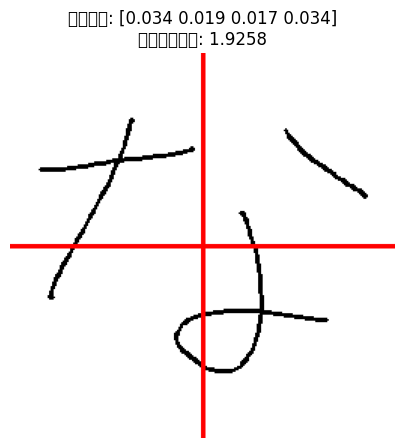

In [51]:
# --- 分割線を描画 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)  # 垂直線
cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)  # 水平線

# --- 表示 ---
plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"黒画素率: {np.round(black_ratios, 3)}\nエントロピー: {entropy:.4f}")
plt.axis("off")
plt.show()

上の黒画素率: 0.0263
下の黒画素率: 0.0252
黒画素率の比（上:下）= 1.0461


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


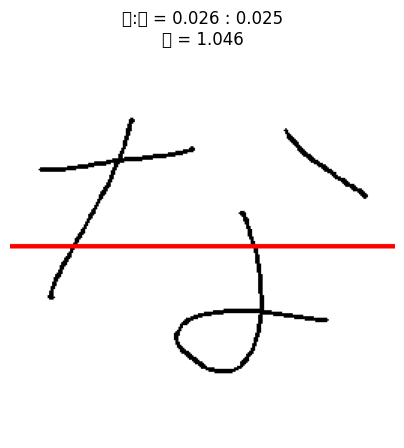

In [52]:
#上下黒画素率比
# --- 画像読み込み（グレースケール） ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字→白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 画像サイズ取得 ---
h, w = bin_img.shape
h_half = h // 2

# --- 上下2分割 ---
top = bin_img[0:h_half, :]
bottom = bin_img[h_half:h, :]

# --- 各領域の黒画素率を計算 ---
def black_ratio(region):
    return np.sum(region > 0) / region.size

top_ratio = black_ratio(top)
bottom_ratio = black_ratio(bottom)

# --- 黒画素率の比（上:下）を計算 ---
# 下が0の場合のエラー防止
ratio = top_ratio / bottom_ratio if bottom_ratio > 0 else np.inf

# --- 結果出力 ---
print(f"上の黒画素率: {top_ratio:.4f}")
print(f"下の黒画素率: {bottom_ratio:.4f}")
print(f"黒画素率の比（上:下）= {ratio:.4f}")

# --- 可視化 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"上:下 = {top_ratio:.3f} : {bottom_ratio:.3f}\n比 = {ratio:.3f}")
plt.axis("off")
plt.show()


左の黒画素率: 0.0254
右の黒画素率: 0.0261
黒画素率の比（左:右）= 0.9720


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24038 (\N{CJK UNIFIED IDEOGRAPH-5DE6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21491 (\N{CJK UNIFIED IDEOGRAPH-53F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


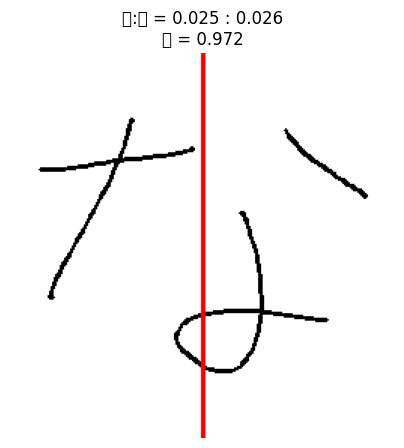

In [53]:
#左右黒画素率比
# --- 画像読み込み（グレースケール） ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字→白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 画像サイズ取得 ---
h, w = bin_img.shape
w_half = w // 2

# --- 左右2分割 ---
left = bin_img[:, 0:w_half]
right = bin_img[:, w_half:w]

# --- 各領域の黒画素率を計算 ---
def black_ratio(region):
    return np.sum(region > 0) / region.size

left_ratio = black_ratio(left)
right_ratio = black_ratio(right)

# --- 黒画素率の比（左:右）を計算 ---
ratio = left_ratio / right_ratio if right_ratio > 0 else np.inf

# --- 結果出力 ---
print(f"左の黒画素率: {left_ratio:.4f}")
print(f"右の黒画素率: {right_ratio:.4f}")
print(f"黒画素率の比（左:右）= {ratio:.4f}")

# --- 可視化 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"左:右 = {left_ratio:.3f} : {right_ratio:.3f}\n比 = {ratio:.3f}")
plt.axis("off")
plt.show()


第1象限: 0.0186
第2象限: 0.0341
第3象限: 0.0167
第4象限: 0.0337
対角黒画素率比 (1+3) / (2+4) = 0.5194


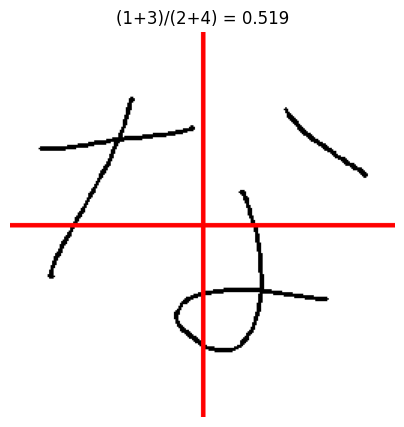

In [54]:
#対角黒画素率比
# --- 画像読み込み（グレースケール） ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字→白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- サイズ取得 ---
h, w = bin_img.shape
h_half, w_half = h // 2, w // 2

# --- 4分割 ---
q1 = bin_img[0:h_half, w_half:w]     # 第1象限（右上）
q2 = bin_img[0:h_half, 0:w_half]     # 第2象限（左上）
q3 = bin_img[h_half:h, 0:w_half]     # 第3象限（左下）
q4 = bin_img[h_half:h, w_half:w]     # 第4象限（右下）

# --- 黒画素率計算 ---
def black_ratio(region):
    return np.sum(region > 0) / region.size

r1, r2, r3, r4 = map(black_ratio, [q1, q2, q3, q4])

# --- 対角比 (第1+第3) / (第2+第4) ---
num = r1 + r3
den = r2 + r4
diag_ratio = num / den if den > 0 else np.inf

# --- 結果出力 ---
print(f"第1象限: {r1:.4f}")
print(f"第2象限: {r2:.4f}")
print(f"第3象限: {r3:.4f}")
print(f"第4象限: {r4:.4f}")
print(f"対角黒画素率比 (1+3) / (2+4) = {diag_ratio:.4f}")

# --- 可視化 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)
cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"(1+3)/(2+4) = {diag_ratio:.3f}")
plt.axis("off")
plt.show()

第1象限の距離: 81.15
第2象限の距離: 78.48
第3象限の距離: 63.78
第4象限の距離: 59.49

距離のエントロピー: 1.9876


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


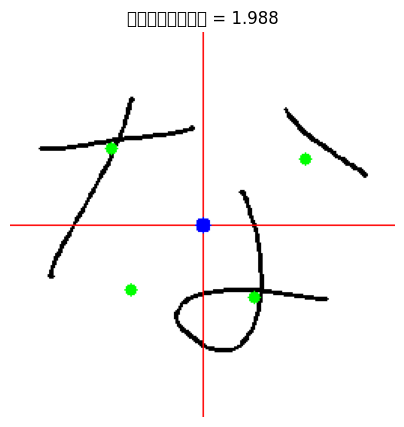

In [55]:
#4分割重心距離エントロピー
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字を白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- サイズと中心 ---
h, w = bin_img.shape
h_half, w_half = h // 2, w // 2
center = np.array([w / 2, h / 2])

# --- 4分割（完全4等分版） ---
q1 = bin_img[0:h_half, w_half:w]      # 第1象限（右上）
q2 = bin_img[0:h_half, 0:w_half]      # 第2象限（左上）
q3 = bin_img[h_half:h, 0:w_half]      # 第3象限（左下）
q4 = bin_img[h_half:h, w_half:w]      # 第4象限（右下）
quadrants = [q1, q2, q3, q4]

# --- 各領域のオフセット（座標原点を画像全体座標系に合わせる） ---
offsets = [
    (w_half, 0),     # q1
    (0, 0),          # q2
    (0, h_half),     # q3
    (w_half, h_half) # q4
]

# --- 各領域の重心を求める ---
centroids = []
for q, (ox, oy) in zip(quadrants, offsets):
    ys, xs = np.where(q > 0)
    if len(xs) == 0:
        centroids.append(None)
        continue
    cx = np.mean(xs) + ox
    cy = np.mean(ys) + oy
    centroids.append(np.array([cx, cy]))

# --- 画像中心からの距離を計算 ---
distances = []
for c in centroids:
    if c is not None:
        d = np.linalg.norm(c - center)
        distances.append(d)
    else:
        distances.append(0.0)  # 黒画素がない場合は0距離に

# --- 正規化してエントロピーを算出 ---
p = np.array(distances) / np.sum(distances)
entropy = -np.sum(p * np.log2(p + 1e-10))  # 0対策

# --- 結果表示 ---
for i, d in enumerate(distances, start=1):
    print(f"第{i}象限の距離: {d:.2f}")
print(f"\n距離のエントロピー: {entropy:.4f}")

# --- 可視化 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 1)
cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 1)

# 重心点描画
for c in centroids:
    if c is not None:
        cv.circle(vis, (int(c[0]), int(c[1])), 4, (0, 255, 0), -1)

# 中心点描画
cv.circle(vis, (int(center[0]), int(center[1])), 5, (255, 0, 0), -1)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"距離エントロピー = {entropy:.3f}")
plt.axis("off")
plt.show()

各象限の角度（ラジアン）:
第1象限: 0.568 rad
第2象限: 2.447 rad
第3象限: -2.400 rad
第4象限: -0.945 rad

平均角度: -1.816 rad
円周標準偏差: 2.2507


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEOGRAPH-5186}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

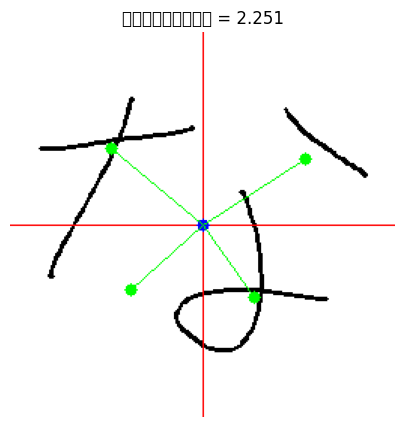

In [56]:
#4分割重心角度標準偏差
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字→白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- サイズと中心 ---
h, w = bin_img.shape
h_half, w_half = h // 2, w // 2
center = np.array([w / 2, h / 2])

# --- 4分割 ---
q1 = bin_img[0:h_half, w_half:w]      # 第1象限（右上）
q2 = bin_img[0:h_half, 0:w_half]      # 第2象限（左上）
q3 = bin_img[h_half:h, 0:w_half]      # 第3象限（左下）
q4 = bin_img[h_half:h, w_half:w]      # 第4象限（右下）
quadrants = [q1, q2, q3, q4]

# --- 各領域のオフセット ---
offsets = [
    (w_half, 0),     # q1
    (0, 0),          # q2
    (0, h_half),     # q3
    (w_half, h_half) # q4
]

# --- 各領域の重心 ---
centroids = []
for q, (ox, oy) in zip(quadrants, offsets):
    ys, xs = np.where(q > 0)
    if len(xs) == 0:
        centroids.append(None)
        continue
    cx = np.mean(xs) + ox
    cy = np.mean(ys) + oy
    centroids.append(np.array([cx, cy]))

# --- 中心→重心ベクトルの角度を求める ---
angles = []
for c in centroids:
    if c is not None:
        dx, dy = c - center
        angle = np.arctan2(-dy, dx)  # y軸下向き補正（画像座標系→通常座標系）
        angles.append(angle)
angles = np.array(angles)

# --- 円周統計: 標準偏差 ---
mean_angle = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))
R = np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2)
circ_std = np.sqrt(-2 * np.log(R))

# --- 結果 ---
print("各象限の角度（ラジアン）:")
for i, a in enumerate(angles, start=1):
    print(f"第{i}象限: {a:.3f} rad")
print(f"\n平均角度: {mean_angle:.3f} rad")
print(f"円周標準偏差: {circ_std:.4f}")

# --- 可視化 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 1)
cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 1)
cv.circle(vis, (int(center[0]), int(center[1])), 4, (255, 0, 0), -1)

# 各重心を描画 + ベクトル線
for c in centroids:
    if c is not None:
        cv.circle(vis, (int(c[0]), int(c[1])), 4, (0, 255, 0), -1)
        cv.line(vis, (int(center[0]), int(center[1])), (int(c[0]), int(c[1])), (0, 255, 0), 1)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"角度の円周標準偏差 = {circ_std:.3f}")
plt.axis("off")
plt.show()

上側重心のx座標: 113.04
下側重心のx座標: 135.74
x方向の差（上 - 下）: -22.69


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


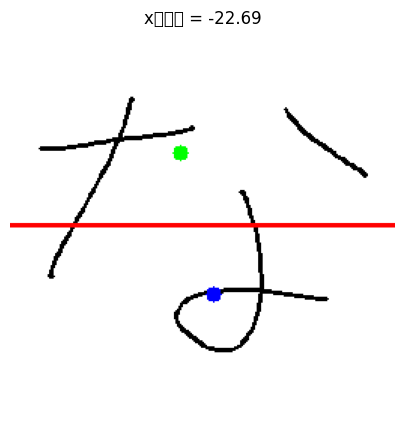

In [57]:
#上下重心距離差
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字を白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- サイズ取得 ---
h, w = bin_img.shape
h_half = h // 2

# --- 上下2分割 ---
top = bin_img[0:h_half, :]
bottom = bin_img[h_half:h, :]

# --- 黒画素の重心を求める関数 ---
def centroid(region, offset_y=0):
    ys, xs = np.where(region > 0)
    if len(xs) == 0:
        return None
    cx = np.mean(xs)
    cy = np.mean(ys) + offset_y
    return np.array([cx, cy])

# --- 各領域の重心 ---
top_c = centroid(top, 0)
bottom_c = centroid(bottom, h_half)

# --- x座標の差 ---
if top_c is not None and bottom_c is not None:
    dx = top_c[0] - bottom_c[0]
else:
    dx = np.nan

print(f"上側重心のx座標: {top_c[0]:.2f}")
print(f"下側重心のx座標: {bottom_c[0]:.2f}")
print(f"x方向の差（上 - 下）: {dx:.2f}")

# --- 可視化 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (0, h_half), (w, h_half), (0, 0, 255), 2)  # 分割線

# 重心を描画
for c, color in zip([top_c, bottom_c], [(0,255,0), (255,0,0)]):
    if c is not None:
        cv.circle(vis, (int(c[0]), int(c[1])), 5, color, -1)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"x方向差 = {dx:.2f}")
plt.axis("off")
plt.show()

左側重心のy座標: 108.39
右側重心のy座標: 143.60
y方向の差（左 - 右）: -35.21


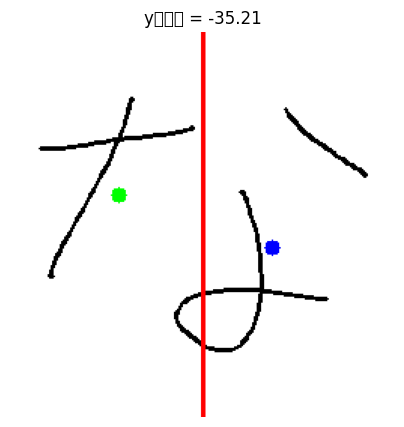

In [58]:
#左右重心距離差
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字→白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- サイズ取得 ---
h, w = bin_img.shape
w_half = w // 2

# --- 左右2分割 ---
left = bin_img[:, 0:w_half]
right = bin_img[:, w_half:w]

# --- 黒画素の重心を求める関数 ---
def centroid(region, offset_x=0):
    ys, xs = np.where(region > 0)
    if len(xs) == 0:
        return None
    cx = np.mean(xs) + offset_x
    cy = np.mean(ys)
    return np.array([cx, cy])

# --- 各領域の重心 ---
left_c = centroid(left, 0)
right_c = centroid(right, w_half)

# --- y座標の差 ---
if left_c is not None and right_c is not None:
    dy = left_c[1] - right_c[1]
else:
    dy = np.nan

print(f"左側重心のy座標: {left_c[1]:.2f}")
print(f"右側重心のy座標: {right_c[1]:.2f}")
print(f"y方向の差（左 - 右）: {dy:.2f}")

# --- 可視化 ---
vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.line(vis, (w_half, 0), (w_half, h), (0, 0, 255), 2)  # 分割線

# 重心を描画
for c, color in zip([left_c, right_c], [(0,255,0), (255,0,0)]):
    if c is not None:
        cv.circle(vis, (int(c[0]), int(c[1])), 5, color, -1)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title(f"y方向差 = {dy:.2f}")
plt.axis("off")
plt.show()

In [59]:
#部分系長さ
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字を白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 連結成分解析 ---
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

# --- 背景(ラベル0)を除く ---
areas = stats[1:, cv.CC_STAT_AREA]  # 1番目以降が文字部分

print("各部分系の黒画素数（背景除く）:")
for i, area in enumerate(areas, start=1):
    print(f"部分系 {i}: {area} pixels")


各部分系の黒画素数（背景除く）:
部分系 1: 677 pixels
部分系 2: 232 pixels
部分系 3: 779 pixels


In [60]:
#部分系長さの比やエントロピー
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字を白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 連結成分解析 ---
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

# --- 背景を除いた部分系の黒画素数 ---
areas = stats[1:, cv.CC_STAT_AREA]  # 背景を除く
n = len(areas)

print(f"部分系の数: {n}")

# --- 場合分け ---
if n == 0:
    print("黒画素の連結成分が存在しません。")

elif n == 1:
    print("部分系が1つのため、比・エントロピーはなし。")

elif n == 2:
    ratio = max(areas) / min(areas)
    print(f"部分系が2つ → 面積比 = {ratio:.3f}")

else:
    # --- エントロピーを手計算で求める ---
    p = areas / np.sum(areas)  # 各部分系の黒画素割合
    entropy = -np.sum(p * np.log2(p + 1e-12))  # log(0)防止のため微小値を加算
    print(f"部分系が{n}個 → 黒画素分布のエントロピー = {entropy:.3f} bits")


部分系の数: 3
部分系が3個 → 黒画素分布のエントロピー = 1.437 bits


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


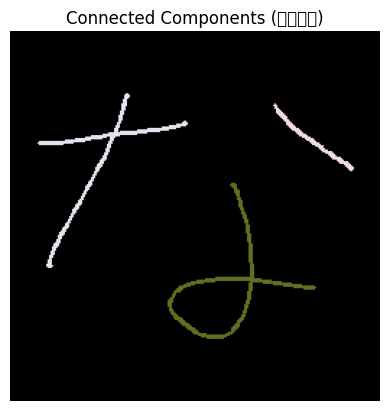

In [61]:
#部分系の表示
colored = np.zeros((*bin_img.shape, 3), dtype=np.uint8)
for i in range(1, num_labels):
    color = np.random.randint(0, 255, size=3).tolist()
    colored[labels == i] = color

plt.imshow(colored)
plt.title("Connected Components (各部分系)")
plt.axis("off")
plt.show()


In [62]:
#部分系外接矩形面積
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字を白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 連結成分解析 ---
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

print("各部分系の外接矩形の面積（背景除く）:")
for i in range(1, num_labels):  # 0は背景
    x, y, w, h, area = stats[i]
    bbox_area = w * h
    print(f"部分系 {i}: 外接矩形面積 = {bbox_area}")


各部分系の外接矩形の面積（背景除く）:
部分系 1: 外接矩形面積 = 12584
部分系 2: 外接矩形面積 = 2632
部分系 3: 外接矩形面積 = 11124


In [63]:
#部分系面積の比やエントロピー
# --- 画像読み込み ---
img = cv.imread("A.png", cv.IMREAD_GRAYSCALE)

# --- 二値化（黒文字を白に反転）---
_, bin_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# --- 連結成分解析 ---
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(bin_img)

# --- 背景を除いた外接矩形の面積 ---
widths  = stats[1:, cv.CC_STAT_WIDTH]
heights = stats[1:, cv.CC_STAT_HEIGHT]
bbox_areas = widths * heights
n = len(bbox_areas)

print(f"部分系の数: {n}")

# --- 場合分け ---
if n == 0:
    print("黒画素の連結成分が存在しません。")

elif n == 1:
    print("部分系が1つのため、比・エントロピーはなし。")

elif n == 2:
    ratio = max(bbox_areas) / min(bbox_areas)
    print(f"部分系が2つ → 外接矩形面積比 = {ratio:.3f}")

else:
    # --- エントロピー（手計算）---
    p = bbox_areas / np.sum(bbox_areas)
    entropy = -np.sum(p * np.log2(p + 1e-12))
    print(f"部分系が{n}個 → 外接矩形面積分布のエントロピー = {entropy:.3f} bits")


部分系の数: 3
部分系が3個 → 外接矩形面積分布のエントロピー = 1.366 bits


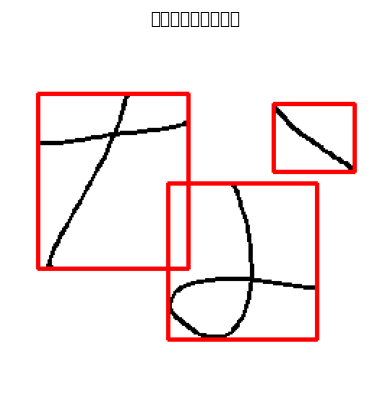

In [64]:
#部分系外接矩形面積の表示
colored = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    cv.rectangle(colored, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.imshow(cv.cvtColor(colored, cv.COLOR_BGR2RGB))
plt.title("各部分系の外接矩形")
plt.axis("off")
plt.show()


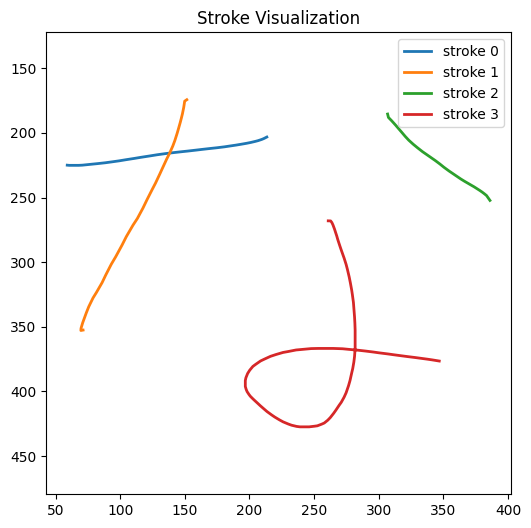

In [65]:
#ストロークの抽出
# --- データ読み込み ---
df = pd.read_csv("A.txt")

# --- stroke_idごとにグループ化 ---
groups = df.groupby("stroke_id")

# --- 描画 ---
plt.figure(figsize=(6, 6))
for stroke_id, g in groups:
    plt.plot(g["x"], g["y"], linewidth=2, label=f"stroke {stroke_id}")

plt.gca().invert_yaxis()  # 画像と同じ座標系にする（y軸反転）
plt.axis("equal")
plt.legend()
plt.title("Stroke Visualization")
plt.show()


ストローク数: 4
各ストロークの画素数: [306, 381, 232, 779]
ストロークが4本 → 画素数分布のエントロピー = 1.837 bits


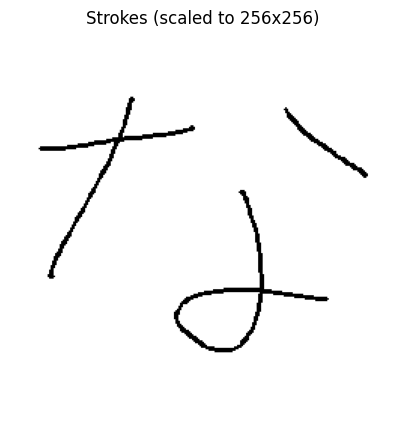

In [66]:
#ストローク長さの比やエントロピー
# --- ① TXT読み込み ---
txt_file = "A.txt"
df = pd.read_csv(txt_file, sep=',')
df[['x','y','stroke_id']] = df[['x','y','stroke_id']].astype(float)

# --- ② スケーリング・位置補正 ---
x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()
w, h = x_max - x_min, y_max - y_min

out_size = 256
margin = 20
scale = (out_size - 2*margin) / max(w, h)
offset_x = margin + (out_size - 2*margin - w*scale)/2
offset_y = margin + (out_size - 2*margin - h*scale)/2

# --- ③ 各ストロークの画素数を求める ---
stroke_pixels = []

for sid in df['stroke_id'].unique():
    stroke = df[df['stroke_id'] == sid].reset_index(drop=True)

    # ストロークごとのキャンバス
    stroke_img = np.zeros((out_size, out_size), dtype=np.uint8)

    for i in range(1, len(stroke)):
        x0 = int((stroke.loc[i-1, 'x'] - x_min) * scale + offset_x)
        y0 = int((stroke.loc[i-1, 'y'] - y_min) * scale + offset_y)
        x1 = int((stroke.loc[i, 'x'] - x_min) * scale + offset_x)
        y1 = int((stroke.loc[i, 'y'] - y_min) * scale + offset_y)
        cv.line(stroke_img, (x0, y0), (x1, y1), 255, 2)

    pixel_count = np.count_nonzero(stroke_img)
    stroke_pixels.append(pixel_count)

# --- ④ 結果の出力 ---
n = len(stroke_pixels)
print(f"ストローク数: {n}")
print("各ストロークの画素数:", stroke_pixels)

if n == 0:
    print("ストロークが存在しません。")

elif n == 1:
    print("ストロークが1本のため、比・エントロピーはなし。")

elif n == 2:
    ratio = max(stroke_pixels) / min(stroke_pixels)
    print(f"ストロークが2本 → 画素数比 = {ratio:.3f}")

else:
    p = np.array(stroke_pixels) / np.sum(stroke_pixels)
    entropy = -np.sum(p * np.log2(p + 1e-12))
    print(f"ストロークが{n}本 → 画素数分布のエントロピー = {entropy:.3f} bits")

# --- ⑤ 全ストロークを重ねて描画 ---
img = np.ones((out_size, out_size, 3), dtype=np.uint8) * 255
for sid in df['stroke_id'].unique():
    stroke = df[df['stroke_id'] == sid].reset_index(drop=True)
    for i in range(1, len(stroke)):
        x0 = int((stroke.loc[i-1, 'x'] - x_min) * scale + offset_x)
        y0 = int((stroke.loc[i-1, 'y'] - y_min) * scale + offset_y)
        x1 = int((stroke.loc[i, 'x'] - x_min) * scale + offset_x)
        y1 = int((stroke.loc[i, 'y'] - y_min) * scale + offset_y)
        cv.line(img, (x0, y0), (x1, y1), (0,0,0), 2)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Strokes (scaled to 256x256)")
plt.axis("off")
plt.show()


ストローク数: 4
各ストロークの外接矩形面積: [1475.4, 6383.52, 2308.89, 10431.35]
ストロークが4本 → 外接矩形面積分布のエントロピー = 1.647 bits


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figur

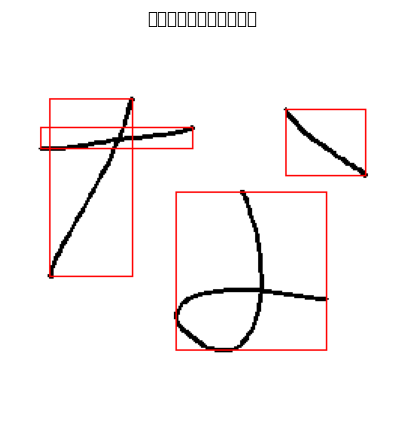

In [67]:
#ストローク面積の比やエントロピー
# --- ① TXT読み込み ---
txt_file = "A.txt"
df = pd.read_csv(txt_file, sep=',')
df[['x','y','stroke_id']] = df[['x','y','stroke_id']].astype(float)

# --- ② スケーリング・位置補正（PNG生成と同じ） ---
x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()
w, h = x_max - x_min, y_max - y_min

out_size = 256
margin = 20
scale = (out_size - 2*margin) / max(w, h)
offset_x = margin + (out_size - 2*margin - w*scale)/2
offset_y = margin + (out_size - 2*margin - h*scale)/2

# --- ③ 各ストロークの外接矩形を求める ---
bbox_areas = []

for sid in df['stroke_id'].unique():
    stroke = df[df['stroke_id'] == sid].reset_index(drop=True)

    xs = (stroke['x'] - x_min) * scale + offset_x
    ys = (stroke['y'] - y_min) * scale + offset_y

    x_min_s, x_max_s = xs.min(), xs.max()
    y_min_s, y_max_s = ys.min(), ys.max()

    w_s = x_max_s - x_min_s
    h_s = y_max_s - y_min_s
    area = w_s * h_s
    bbox_areas.append(area)

# --- ④ 場合分けで出力 ---
n = len(bbox_areas)
print(f"ストローク数: {n}")
print("各ストロークの外接矩形面積:", [round(a, 2) for a in bbox_areas])

if n == 0:
    print("ストロークが存在しません。")

elif n == 1:
    print("ストロークが1本のため、比・エントロピーはなし。")

elif n == 2:
    ratio = max(bbox_areas) / min(bbox_areas)
    print(f"ストロークが2本 → 外接矩形面積比 = {ratio:.3f}")

else:
    p = np.array(bbox_areas) / np.sum(bbox_areas)
    entropy = -np.sum(p * np.log2(p + 1e-12))
    print(f"ストロークが{n}本 → 外接矩形面積分布のエントロピー = {entropy:.3f} bits")

# --- ⑤ 可視化（任意）---
img = np.ones((out_size, out_size, 3), dtype=np.uint8) * 255
for sid in df['stroke_id'].unique():
    stroke = df[df['stroke_id'] == sid].reset_index(drop=True)
    for i in range(1, len(stroke)):
        x0 = int((stroke.loc[i-1, 'x'] - x_min) * scale + offset_x)
        y0 = int((stroke.loc[i-1, 'y'] - y_min) * scale + offset_y)
        x1 = int((stroke.loc[i, 'x'] - x_min) * scale + offset_x)
        y1 = int((stroke.loc[i, 'y'] - y_min) * scale + offset_y)
        cv.line(img, (x0, y0), (x1, y1), (0,0,0), 2)

# 外接矩形を描画して確認
for sid, area in zip(df['stroke_id'].unique(), bbox_areas):
    stroke = df[df['stroke_id'] == sid]
    xs = (stroke['x'] - x_min) * scale + offset_x
    ys = (stroke['y'] - y_min) * scale + offset_y
    x_min_s, x_max_s = int(xs.min()), int(xs.max())
    y_min_s, y_max_s = int(ys.min()), int(ys.max())
    cv.rectangle(img, (x_min_s, y_min_s), (x_max_s, y_max_s), (0,0,255), 1)

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("各ストロークの外接矩形")
plt.axis("off")
plt.show()
